In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sqlalchemy import create_engine

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE


pd.options.display.max_rows = 200
pd.options.display.max_columns = 200
sns.set_theme(style="white")

UNKNOWN = 'unknown'
RANDOM_STATE = 2021

## Import protest data

In [2]:
engine_protests = create_engine('sqlite:///../data/processed/protests.db')


with engine_protests.begin() as connection:
    protests = pd.read_sql('SELECT * FROM protests', connection)
    
protests['start_datetime'] = pd.to_datetime(protests.start_datetime)
protests['end_datetime'] = pd.to_datetime(protests.end_datetime)

AttributeError: 'DataFrame' object has no attribute 'start_datetime'

In [3]:
protests.head(3)

,id,country,location,region,protestnumber,protesterviolence,protesteridentity,startyear,startmonth,startday,endyear,endmonth,endday,start_datetime,end_datetime,duration_days,participants,participants_category_original,participants_category_manufactured,sources,notes,demand_labor-wage-dispute,demand_land-farm-issue,demand_police-brutality,demand_political-behavior/process,demand_price-increases/tax-policy,demand_removal-of-politician,demand_social-restrictions,response_accomodation,response_arrests,response_beatings,response_crowd-dispersal,response_ignore,response_killings,response_shootings
0,201990001,Canada,national,North America,1,0,unknown,1990,1,15,1990,1,15,1990-01-15,1990-01-15,0,1000,unknown,1000-1999,1. great canadian train journeys into history;...,canada s railway passenger system was finally ...,1,0,0,1,0,0,0,0,0,0,0,1,0,0
1,201990002,Canada,"Montreal, Quebec",North America,2,0,unknown,1990,6,25,1990,6,25,1990-06-25,1990-06-25,0,1000,unknown,1000-1999,1. autonomy s cry revived in quebec the new yo...,protestors were only identified as young peopl...,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,201990003,Canada,"Montreal, Quebec",North America,3,0,separatist parti quebecois,1990,7,1,1990,7,1,1990-07-01,1990-07-01,0,500,unknown,100-999,1. quebec protest after queen calls for unity ...,"the queen, after calling on canadians to remai...",0,0,0,1,0,0,0,0,0,0,0,1,0,0


## Narrow to select features

In [4]:
protests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15208 entries, 0 to 15207
Data columns (total 35 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   id                                  15208 non-null  int64         
 1   country                             15208 non-null  object        
 2   location                            15208 non-null  object        
 3   region                              15208 non-null  object        
 4   protestnumber                       15208 non-null  int64         
 5   protesterviolence                   15208 non-null  int64         
 6   protesteridentity                   15208 non-null  object        
 7   startyear                           15208 non-null  int64         
 8   startmonth                          15208 non-null  int64         
 9   startday                            15208 non-null  int64         
 10  endyear               

In [5]:
response_cols = ['response_accomodation', 'response_arrests', 'response_beatings', 
                 'response_crowd-dispersal', 'response_ignore', 'response_killings', 'response_shootings']

In [6]:
model_inputs = protests.drop(response_cols+['id', 'location', 'protesteridentity', 'start_datetime', 'end_datetime', 'sources', 'notes', 'endday', 'endmonth', 'endyear', 'participants_category_original', 'country'], axis=1)
model_inputs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15208 entries, 0 to 15207
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   region                              15208 non-null  object
 1   protestnumber                       15208 non-null  int64 
 2   protesterviolence                   15208 non-null  int64 
 3   startyear                           15208 non-null  int64 
 4   startmonth                          15208 non-null  int64 
 5   startday                            15208 non-null  int64 
 6   duration_days                       15208 non-null  int64 
 7   participants                        15208 non-null  int64 
 8   participants_category_manufactured  15208 non-null  object
 9   demand_labor-wage-dispute           15208 non-null  int64 
 10  demand_land-farm-issue              15208 non-null  int64 
 11  demand_police-brutality             15208 non-null  in

## Correlation matrix

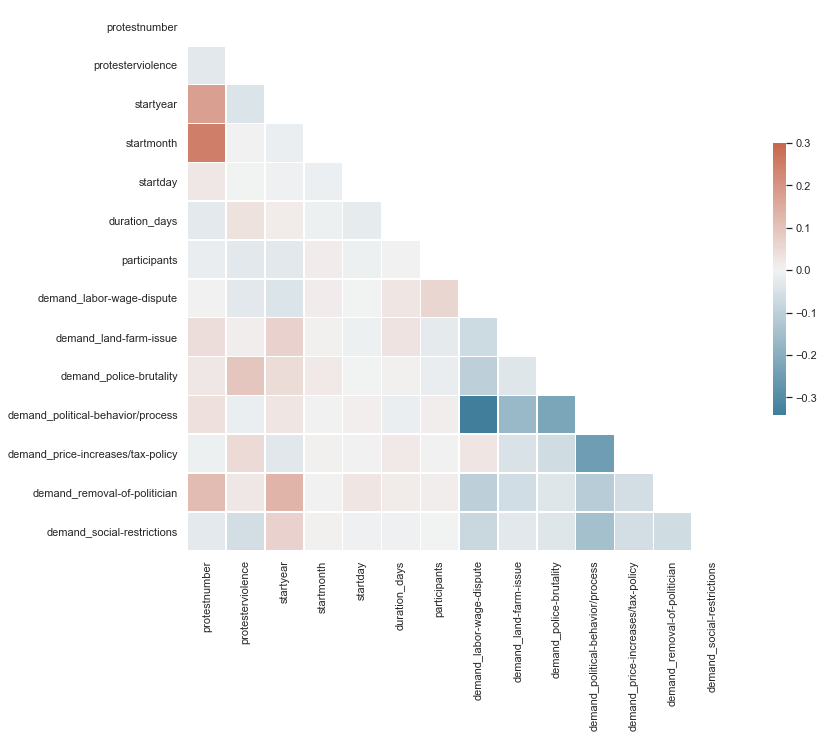

In [7]:
# Compute the correlation matrix
corr = model_inputs.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(15, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

## Modeling

In [8]:
model_inputs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15208 entries, 0 to 15207
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   region                              15208 non-null  object
 1   protestnumber                       15208 non-null  int64 
 2   protesterviolence                   15208 non-null  int64 
 3   startyear                           15208 non-null  int64 
 4   startmonth                          15208 non-null  int64 
 5   startday                            15208 non-null  int64 
 6   duration_days                       15208 non-null  int64 
 7   participants                        15208 non-null  int64 
 8   participants_category_manufactured  15208 non-null  object
 9   demand_labor-wage-dispute           15208 non-null  int64 
 10  demand_land-farm-issue              15208 non-null  int64 
 11  demand_police-brutality             15208 non-null  in

In [9]:
violent_cols = ['response_beatings', 'response_killings', 'response_shootings']
violent_response = protests[violent_cols].any(axis=1).astype('int')
accommodation = protests['response_accomodation']

y = violent_response #IMPORTANT LINE - CHOOSE WHICH TARGET TO USE
x_train, x_test, y_train, y_test = train_test_split(model_inputs, y, random_state=RANDOM_STATE)

### Define models and parameter grids

In [17]:
# Set parameter grid to search across
param_grid_logreg = {'model__C': np.logspace(-1, 5, 20)}


param_grid_dt = {
    'model__max_depth': [3, 5, 7], 
    'model__criterion': ['gini', 'entropy'],
    'model__min_samples_split': [5, 10],
    'model__min_samples_leaf': [5, 10]} 

param_grid_rf = {
    'model__n_estimators': [25, 75],#, 150],
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [3, 7],# [3, 6, 10],
    'model__min_samples_split': [5, 10],
    'model__min_samples_leaf': [3, 6]}


param_grid_knn = {
    'model__leaf_size': [25, 50, 75],
    'model__n_neighbors': [3, 5, 7, 9]}#,
    #'model__weights': ['uniform', 'distance'],
    #'model__metric': ['euclindean', 'manhattan', 'minkowski']} 
        
        
param_grid_xgb = {
    'model__learning_rate': [0.1, 0.2],
    'model__max_depth': [3, 7],
    #'model__min_child_weight': [1, 2],
    #'model__subsample': [0.5, 0.7],
    'model__n_estimators': [100, 150]}#,
    #'model__tree_method': ['exact', 'approx', 'hist']}


np.random.seed(RANDOM_STATE)
model_logreg = LogisticRegression(max_iter=5000)
model_dt = DecisionTreeClassifier()
model_rf = RandomForestClassifier()
model_knn = KNeighborsClassifier()
model_xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False)

grids = [param_grid_logreg, param_grid_dt, param_grid_rf, param_grid_knn, param_grid_xgb]
models = [model_logreg, model_dt, model_rf, model_knn, model_xgb]

### No need to edit anything in below cell. Run cell to evaluate model.

In [18]:
def create_pipeline_and_run(model, param_grid, metric='accuracy'):
    np.random.seed(RANDOM_STATE)
    ohe = OneHotEncoder()
    scaler = StandardScaler()
    smote = SMOTE()

    selector_object = make_column_selector(dtype_include='object')
    selector_numeric = make_column_selector(dtype_include='number')
    transformer = make_column_transformer((ohe, selector_object),
                                         (scaler, selector_numeric))


    pipe = Pipeline([('transformer', transformer),
                     ('smote', smote), 
                     ('model', model)])

    # Instantiate and fit grid search object
    grid = GridSearchCV(pipe, param_grid, return_train_score=True, scoring=metric, cv=3)
    grid.fit(x_train, y_train)
    print(f'{model} {metric}: {grid.score(x_test, y_test)}')
    return grid.best_estimator_

### Select your model and grid from above list to run one selected model

In [1]:
create_pipeline_and_run(model_bay, param_grid_bay);

NameError: name 'create_pipeline_and_run' is not defined

### Run below cell to iterate over *all* above-defined models

In [20]:
pipes = []
for grid, model in zip(grids, models):
    pipe = create_pipeline_and_run(model, grid)
    pipes.append(pipe)

LogisticRegression(max_iter=5000) accuracy: 0.7611783271962125
DecisionTreeClassifier() accuracy: 0.8211467648605997
RandomForestClassifier() accuracy: 0.8190426091530774
KNeighborsClassifier() accuracy: 0.7772225144660705
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              eval_metric='logloss', gamma=None, gpu_id=None,
              importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              use_label_encoder=False, validate_parameters=None,
              verbosity=None) accuracy: 0.8700683850604944


In [21]:
from sklearn.dummy import DummyClassifier

for strategy in ["stratified", "most_frequent", "uniform"]:
    dummy_clf = DummyClassifier(strategy=strategy, random_state=RANDOM_STATE)
    dummy_clf.fit(x_train, y_train)
    print(strategy, '-', dummy_clf.score(x_test, y_test))

stratified - 0.7843240399789585
most_frequent - 0.8763808521830615
uniform - 0.5018411362440821


## Re-evaluate model inputs - why is model worthless?

In [22]:
model_inputs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15208 entries, 0 to 15207
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   region                              15208 non-null  object
 1   protestnumber                       15208 non-null  int64 
 2   protesterviolence                   15208 non-null  int64 
 3   startyear                           15208 non-null  int64 
 4   startmonth                          15208 non-null  int64 
 5   startday                            15208 non-null  int64 
 6   duration_days                       15208 non-null  int64 
 7   participants                        15208 non-null  int64 
 8   participants_category_manufactured  15208 non-null  object
 9   demand_labor-wage-dispute           15208 non-null  int64 
 10  demand_land-farm-issue              15208 non-null  int64 
 11  demand_police-brutality             15208 non-null  in

In [23]:
model_inputs.region.value_counts()

Europe             4994
Africa             3184
Asia               3109
South America      1658
MENA               1254
North America       526
Central America     445
Oceania              38
Name: region, dtype: int64

<AxesSubplot:>

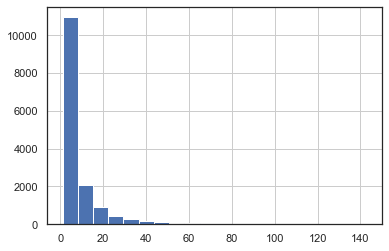

In [24]:
model_inputs.protestnumber.hist(bins=20)

<AxesSubplot:>

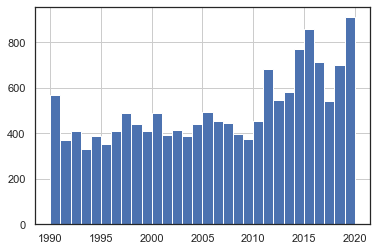

In [25]:
model_inputs.startyear.hist(bins=30)

<AxesSubplot:>

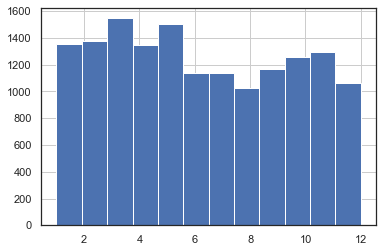

In [26]:
model_inputs.startmonth.hist(bins=12)

<AxesSubplot:>

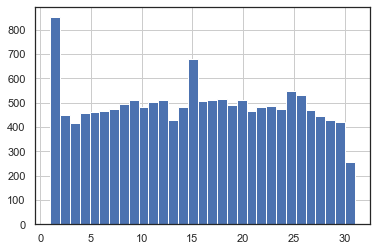

In [27]:
model_inputs.startday.hist(bins=31)

<AxesSubplot:>

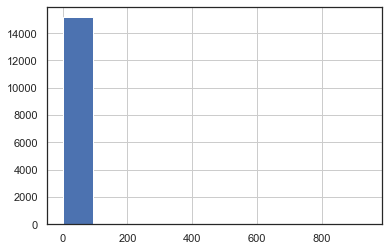

In [28]:
model_inputs.duration_days.hist()

<AxesSubplot:>

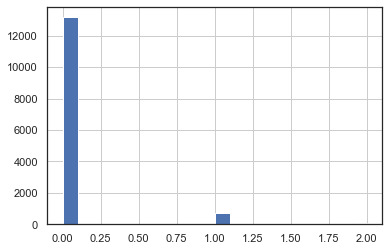

In [29]:
model_inputs.duration_days.sort_values()[:14000].hist(bins=20)

<AxesSubplot:>

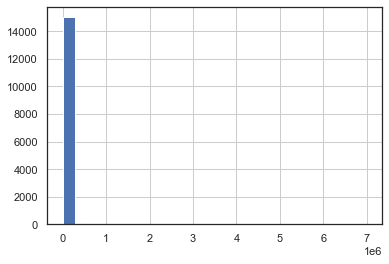

In [30]:
model_inputs.participants.hist(bins=25)

<AxesSubplot:>

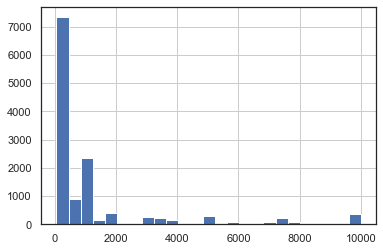

In [31]:
model_inputs.participants.sort_values()[:13000].hist(bins=25)

In [32]:
model_inputs.participants_category_manufactured.value_counts()

100-999      4754
50-99        3475
10000+       2564
1000-1999    2489
2000-4999    1131
5000-9999     795
Name: participants_category_manufactured, dtype: int64

In [33]:
demands = ['demand_labor-wage-dispute', 'demand_land-farm-issue', 'demand_police-brutality', 'demand_political-behavior/process', 'demand_price-increases/tax-policy', 'demand_removal-of-politician', 'demand_social-restrictions']

model_inputs[demands].sum()

demand_labor-wage-dispute             2208
demand_land-farm-issue                 581
demand_police-brutality               1099
demand_political-behavior/process    10729
demand_price-increases/tax-policy     1411
demand_removal-of-politician          1888
demand_social-restrictions             682
dtype: int64

In [34]:
protests[response_cols].sum()

response_accomodation       1526
response_arrests            2145
response_beatings            802
response_crowd-dispersal    4764
response_ignore             8269
response_killings            824
response_shootings           932
dtype: int64